## Ejercicio attrition

1. Carga el dataset [attrition de `kaggle`](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset?resource=download) (Hay que loguearse en kaggle y descargar el csv)
   1. Clasificacion de si el empleado deja o no la empresa (el target es la columna Attrition).
   2. Usaremos TODAS las columnas disponibles del dataset. No hace falta volverse loco con el feature engineering, pero es posible que alguna cosa haya que hacer para poder meter todas las columnas. 
   
2. Prueba todos los métodos de clasificación vistos hasta ahora mediante GridSearchCV (logistic regression, SVM, al menos un metodo de boosting, random forest y MLP). Obligatorio usarlos todos por separado usando pipelines. Se puede hacer todo en sklearn.
   1. Hay que reportar la performance de los modelos con al menos: Accuracy, precission, recall, F1-Score y AUC-ROC
   2. IMPORTANTE: Comentar cual es el mejor metodo y cual es la mejor metrica para este caso de uso concreto.
   
3. Utiliza uno de los métodos para sacar la importancia de las variables del modelo escogido.
   **¿Qué es?**
   Serie de técnicas que asignan puntuaciones a las variables independientes de un modelo predictivo en función de su importancia relativa al realizar una predicción sobre la variable dependiente o target. 
   IMPORTANTE: Antes de obtener el feature importance siempre hay que evaluar la capacidad predictiva del modelo implementado.
   **Tipos**
   1. Métodos "built in" en modelos intrinsecamente intepretables (ya vistos al estudiar los modelos lineales y los modelos basados en árboles de decision). 
   2. Permutation importance
   3. Drop columns importance
   
4. Utilizar un ultimo metodo que sea un stacking (ensemble) de al menos 4 de los metodos anteriores. Obtener las metricas anteriores (acc, prec, recall, etc..)
   
5. Valoracion y comentarios de los resultados obtenidos al final. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.svm import SVC

In [2]:
df= pd.read_csv(r"C:\Users\igbopa\Desktop\REPO TRABAJO\3-Machine_Learning\1-Supervisado\4-Pipelines\data\WA_Fn-UseC_-HR-Employee-Attrition.csv")

df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
df['Attrition'] = df['Attrition'].replace({'Yes': 1, 'No': 0})

C:\Users\igbopa\AppData\Local\Temp\ipykernel_2348\2877373956.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Attrition'] = df['Attrition'].replace({'Yes': 1, 'No': 0})


In [5]:
my_dict1 = {'Non-Travel':0,'Travel_Rarely':1,'Travel_Frequently':2}

df["BusinessTravel"] = df["BusinessTravel"].replace(my_dict1)

C:\Users\igbopa\AppData\Local\Temp\ipykernel_2348\1339615664.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["BusinessTravel"] = df["BusinessTravel"].replace(my_dict1)


In [6]:
department_dummies = pd.get_dummies(df['Department'], dtype=int)
df = pd.concat([df, department_dummies], axis=1)
df.drop(columns=["Department"], axis=1, inplace=True)

In [7]:
educational_field_dummies = pd.get_dummies(df['EducationField'], dtype=int)
df = pd.concat([df, educational_field_dummies], axis=1)
df.drop(columns=["EducationField"], axis=1, inplace=True)

In [8]:
gender_dummies = pd.get_dummies(df['Gender'], dtype=int)
df = pd.concat([df, gender_dummies], axis=1)
df.drop(columns=["Gender"], axis=1, inplace=True)

In [9]:
job_role_dummies = pd.get_dummies(df['JobRole'], dtype=int)
df = pd.concat([df, job_role_dummies], axis=1)
df.drop(columns=["JobRole"], axis=1, inplace=True)

In [10]:
marital_status_dummies = pd.get_dummies(df['MaritalStatus'], dtype=int)
df = pd.concat([df, marital_status_dummies], axis=1)
df.drop(columns=["MaritalStatus"], axis=1, inplace=True)

In [11]:
over18_dummies = pd.get_dummies(df['Over18'], dtype=int)
df = pd.concat([df, over18_dummies], axis=1)
df.drop(columns=["Over18"], axis=1, inplace=True)

In [12]:
overtime_dummies = pd.get_dummies(df['OverTime'], dtype=int)
df = pd.concat([df, overtime_dummies], axis=1)
df.drop(columns=["OverTime"], axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        1470 non-null   int64
 1   Attrition                  1470 non-null   int64
 2   BusinessTravel             1470 non-null   int64
 3   DailyRate                  1470 non-null   int64
 4   DistanceFromHome           1470 non-null   int64
 5   Education                  1470 non-null   int64
 6   EmployeeCount              1470 non-null   int64
 7   EmployeeNumber             1470 non-null   int64
 8   EnvironmentSatisfaction    1470 non-null   int64
 9   HourlyRate                 1470 non-null   int64
 10  JobInvolvement             1470 non-null   int64
 11  JobLevel                   1470 non-null   int64
 12  JobSatisfaction            1470 non-null   int64
 13  MonthlyIncome              1470 non-null   int64
 14  MonthlyRate             

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
Attrition,1470.0,0.161224,0.367863,0.0,0.00,0.0,0.00,1.0
BusinessTravel,1470.0,1.086395,0.532170,0.0,1.00,1.0,1.00,2.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0


In [15]:
corre = df.corr()

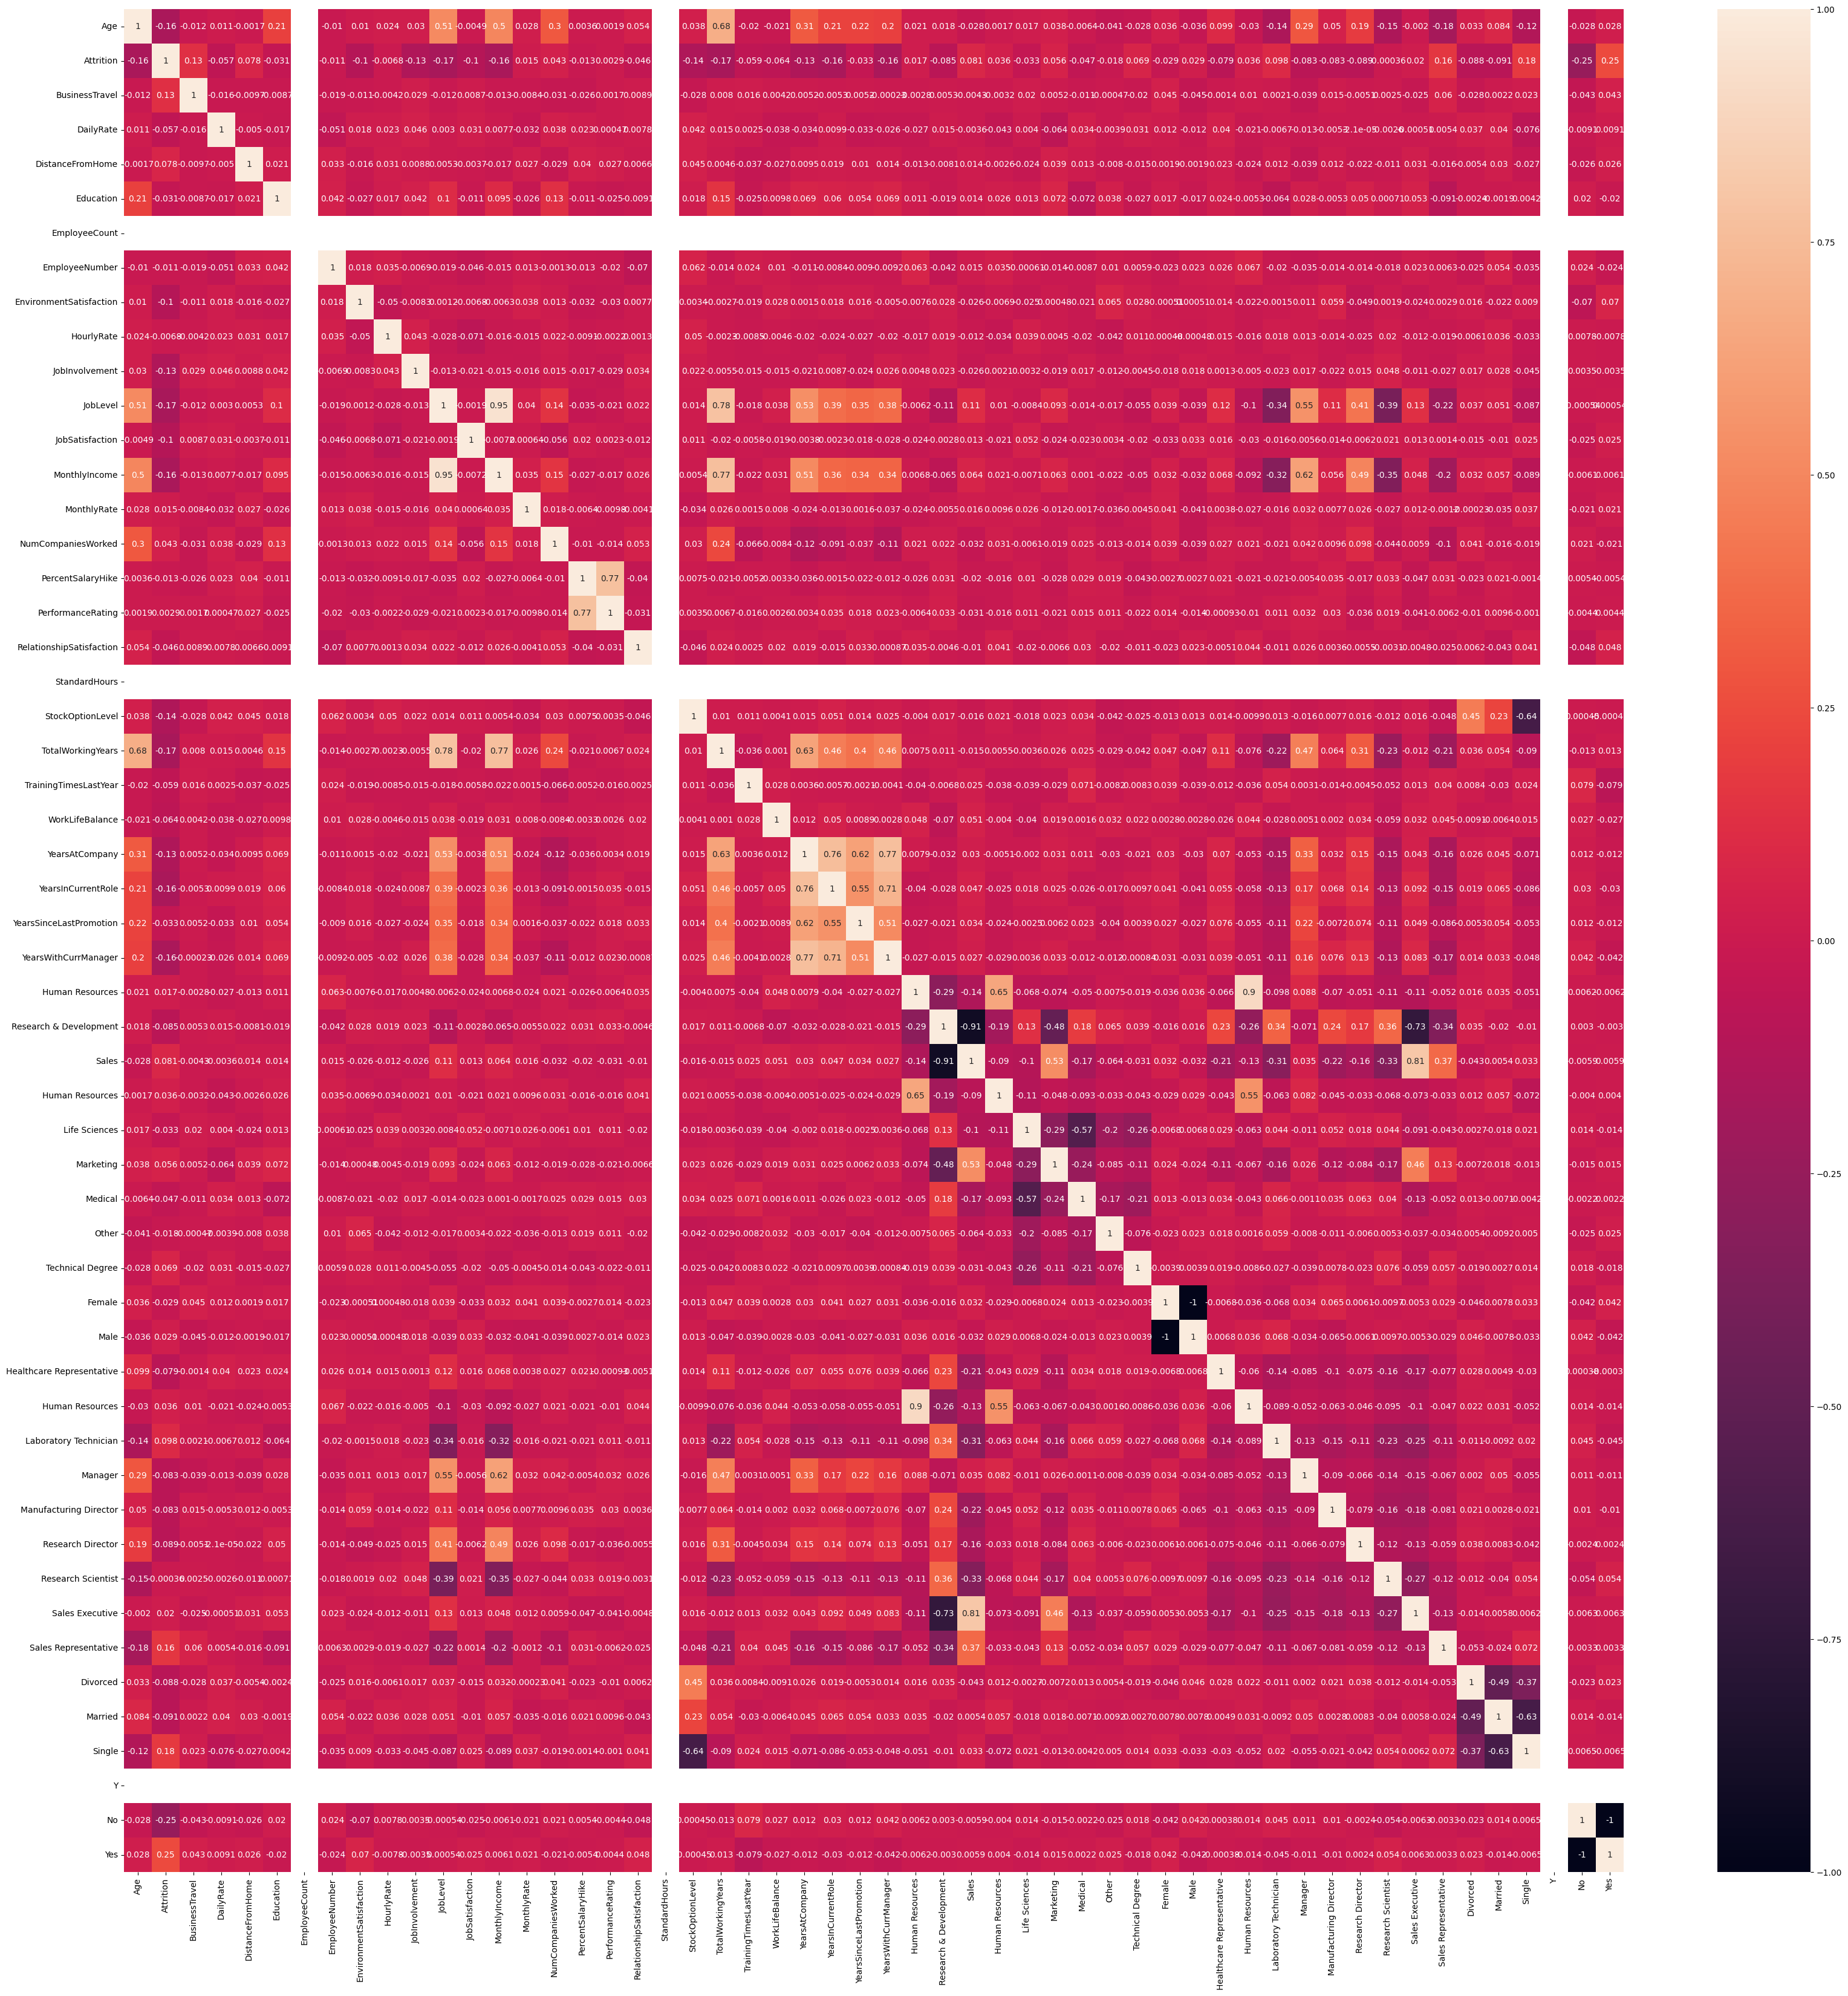

In [16]:
plt.figure(figsize=(40,40))
sns.heatmap(corre, annot=True)
plt.show()

In [17]:
X= df.drop(["Attrition"], axis=1)
X

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,Research Director,Research Scientist,Sales Executive,Sales Representative,Divorced,Married,Single,Y,No,Yes
0,41,1,1102,1,2,1,1,2,94,3,...,0,0,1,0,0,0,1,1,0,1
1,49,2,279,8,1,1,2,3,61,2,...,0,1,0,0,0,1,0,1,1,0
2,37,1,1373,2,2,1,4,4,92,2,...,0,0,0,0,0,0,1,1,0,1
3,33,2,1392,3,4,1,5,4,56,3,...,0,1,0,0,0,1,0,1,0,1
4,27,1,591,2,1,1,7,1,40,3,...,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,2,884,23,2,1,2061,3,41,4,...,0,0,0,0,0,1,0,1,1,0
1466,39,1,613,6,1,1,2062,4,42,2,...,0,0,0,0,0,1,0,1,1,0
1467,27,1,155,4,3,1,2064,2,87,4,...,0,0,0,0,0,1,0,1,0,1
1468,49,2,1023,2,3,1,2065,4,63,2,...,0,0,1,0,0,1,0,1,1,0


In [18]:
y= df["Attrition"]
y

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

In [19]:
#train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)

In [20]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (1176, 53)
X_test (294, 53)
y_train (1176,)
y_test (294,)


In [21]:
RandomForestClassifier??

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Source:        
class RandomForestClassifier(ForestClassifier):
    """
    A random forest classifier.

    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control over-fitting.
    Trees in the forest use the best split strategy, i.e. equivalent to passing
    `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
    The sub-sample size is contr

In [ ]:
"""from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(
    [
        ("rfc", RandomForestClassifier(n_jobs=-1)),
        ("mms", MinMaxScaler()),
        ("lr", LogisticRegression(class_weight="balanced")),
        ("cbc", CatBoostClassifier(verbose=0, thread_count=-1)),
        ("svc", SVC())
    ]
)

param_grid = {
    "rfc__max_depth": [1, 5, 11, 20],
    "rfc__n_estimators": [50, 100, 200, 1000],
    "rfc__max_features": ["log2", "sqrt", None],
    "lr__C": [1, 5, 10],
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "cbc__depth": [3, 6, 9],
    "cbc__learning_rate": [0.1, 0.01, 0.001],
}

pipe_grid = GridSearchCV(pipe,
                         param_grid=param_grid,
                         cv=5,
                         scoring="balanced_accuracy",
                         n_jobs=-1)

pipe_grid.fit(X_train, y_train)"""

In [29]:
from sklearn.preprocessing import MinMaxScaler
mmax = MinMaxScaler()
mmax.fit(X_train)
X_train_scaled = mmax.transform(X_train)
X_test_scaled = mmax.transform(X_test)

In [31]:
cbc = CatBoostClassifier(verbose=0, thread_count=-1)
cbc


In [32]:
cbc.fit(X_train_scaled, y_train)

In [35]:
predictions = cbc.predict(X_test_scaled)

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
accuracy_score(y_test, predictions)

0.8809523809523809

In [38]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       255
           1       0.70      0.18      0.29        39

    accuracy                           0.88       294
   macro avg       0.79      0.58      0.61       294
weighted avg       0.86      0.88      0.85       294

